## Import Libraries and Load the Dataset

In [3]:
import pandas as pd

# Load the dataset
from google.colab import files
uploaded = files.upload()  # Upload the `day.csv` file

# Read the dataset into a DataFrame
file_path = 'day.csv'
bike_data = pd.read_csv(file_path)

# Display basic info about the dataset
bike_data.info()
bike_data.head()


Saving day.csv to day (2).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Data Preparation

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Convert categorical variables into descriptive strings
bike_data['season'] = bike_data['season'].replace({1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"})
bike_data['weathersit'] = bike_data['weathersit'].replace({
    1: "Clear", 2: "Mist", 3: "Light Snow/Rain", 4: "Heavy Rain/Snow"
})

# Drop redundant columns
bike_data = bike_data.drop(columns=['instant', 'dteday', 'casual', 'registered'])

# Scale continuous variables
scaler = MinMaxScaler()
bike_data[['temp', 'atemp', 'hum', 'windspeed']] = scaler.fit_transform(
    bike_data[['temp', 'atemp', 'hum', 'windspeed']]
)

# Dummy encoding for categorical variables
bike_data = pd.get_dummies(bike_data, columns=['season', 'weathersit', 'weekday', 'mnth'], drop_first=True)

# Display the processed data
bike_data.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,0,0.355170,0.373517,0.828620,0.284606,985,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0.379232,0.360541,0.715771,0.466215,801,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,0,1,0.171000,0.144830,0.449638,0.465740,1349,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0,0,1,0.175530,0.174649,0.607131,0.284297,1562,True,False,...,False,False,False,False,False,False,False,False,False,False
4,0,0,1,0.209120,0.197158,0.449313,0.339143,1600,True,False,...,False,False,False,False,False,False,False,False,False,False


# Verifying One-Hot Encoded Columns

In [8]:
# Check all column names in the dataset
print(bike_data.columns)




Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_Spring', 'season_Summer', 'season_Winter',
       'weathersit_Light Snow/Rain', 'weathersit_Mist', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')


# Reconstruct the Original season Column

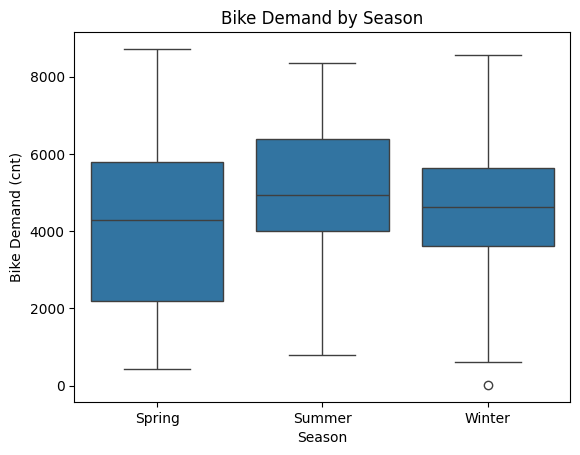

In [9]:
# Reconstruct the original season column from one-hot encoded columns
bike_data['season_category'] = bike_data[['season_Spring', 'season_Summer', 'season_Winter']].idxmax(axis=1)
bike_data['season_category'] = bike_data['season_category'].replace({
    'season_Spring': 'Spring',
    'season_Summer': 'Summer',
    'season_Winter': 'Winter'
}).fillna('Fall')  # Fill 'Fall' for rows without Spring, Summer, or Winter.

# Visualize demand (`cnt`) by reconstructed season
sns.boxplot(data=bike_data, x='season_category', y='cnt')
plt.title("Bike Demand by Season")
plt.xlabel("Season")
plt.ylabel("Bike Demand (cnt)")
plt.show()


# Updated Code for Model Building

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Drop `season_category` if it was created for visualization (not one-hot encoded)
if 'season_category' in bike_data.columns:
    bike_data = bike_data.drop(columns=['season_category'])

# Separate predictors (X) and target variable (y)
X = bike_data.drop(columns=['cnt'])  # Features
y = bike_data['cnt']  # Target

# Ensure all predictors are numeric
print(X.dtypes)  # Confirm that no columns have `object` dtype

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")





yr                              int64
holiday                         int64
workingday                      int64
temp                          float64
atemp                         float64
hum                           float64
windspeed                     float64
season_Spring                    bool
season_Summer                    bool
season_Winter                    bool
weathersit_Light Snow/Rain       bool
weathersit_Mist                  bool
weekday_1                        bool
weekday_2                        bool
weekday_3                        bool
weekday_4                        bool
weekday_5                        bool
weekday_6                        bool
mnth_2                           bool
mnth_3                           bool
mnth_4                           bool
mnth_5                           bool
mnth_6                           bool
mnth_7                           bool
mnth_8                           bool
mnth_9                           bool
mnth_10     

# Residual Analysis

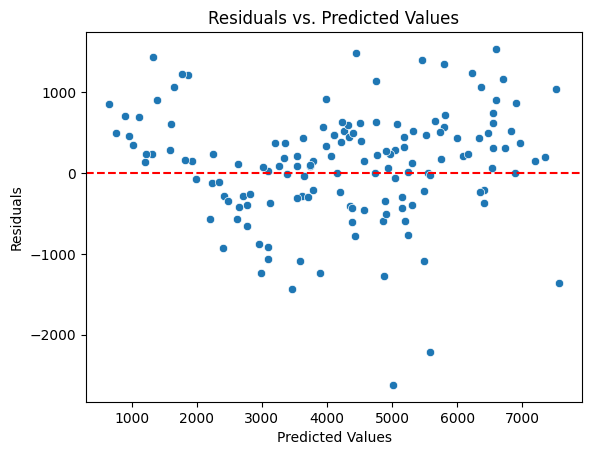

In [12]:
# Residual plot
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


# calculated the R-squared score on the test set

In [13]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8622197210942278